In [5]:
import numpy as np
import numpy.linalg as lin
import numpy.random as npr  
import random
from time import time
from scipy import interpolate 
from scipy.linalg import expm
from scipy.fftpack import fft, ifft
from scipy.fftpack import fft2, ifft2
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

In [6]:
S0, G, T, m, me = 100.0, 100.0, 15, 0.02, 0.011331094393465567
N, X = 1024, 7.5

r = [0.05, 0.02]
sigma = [0.1, 0.3]

A = np.array([[-0.4, 0.4], 
              [0.3, -0.3]])

Pi = np.array([[0.9999], 
               [0.0001]])

In [7]:
def z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    return float(Z)

def rho1_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = -np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One))) / 100
    return float(Z)

def rho2_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z1 = np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One)))
    Z2 = -T * np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    Z = (Z1 + Z2) / 100
    return float(Z)

print(z(r, T, A, Pi)) # 0.5985563466210917
print(rho1_z(r, T, A, Pi)) # -0.08977408189153178
print(rho2_z(r, T, A, Pi)) # -9.370101631969164e-06

0.5985563466210917
-0.08977408189153178
-9.370101631969164e-06


In [8]:
def b(t):
    ini = 0.00495 # aged 50 years old in 2017
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    B = (1 - np.exp(b * t)) / (c + d * np.exp(b * t))
    return B

def s(t):
    ini = 0.00495 # aged 50 years old in 2017
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    # A = 0
    # S_feller = np.exp(A + B(t)*ini)
    S = np.exp((1 - np.exp(b * t)) / (c + d * np.exp(b * t)) * ini)
    return S

print(s(0))
print(s(15))

1.0
0.8672053048004046


## Loss by Monte Carlo

In [11]:
def rsln_gmmbloss_mc(S0, G, T, r, sigma, m, me, A, Pi, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    F = np.zeros((T + 1, I))   
    cf = np.zeros((T + 1, I)) 
    for t in range(T + 1):
        for i in range(I):
            LogStock = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t: # Pr(tau_i > t) = exp(-lambda_i * t)
                p = random.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            SimRand = float(npr.standard_normal())
            LogFund = LogStock + (r1 - m - 0.5 * sigma1 ** 2) * tau1 + (r2 - m - 0.5 * sigma2 ** 2) * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2)
            F[t, i] = np.exp(LogFund)
            if t < T:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.exp(LogFund) * me * s(t)
            else:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.maximum(0, G - np.exp(LogFund))           
    Gmmb = np.mean(s(T) * cf[-1] - np.sum(cf[:-1], 0))
    return (np.mean(cf[-1]), Gmmb)

rsln_gmmbloss_mc(S0, G, T, r, sigma, m, me, A, Pi, 1000000) # 16.276438393834862, -0.009604963120295117

## GMMB and Put by FST

In [9]:
def rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    p1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    p2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, p1)
    f2 = interpolate.PchipInterpolator(ST, p2)
    P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(P)

rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X) # 16.28777319937184

16.28777319937184

In [10]:
def rsln_gmmb_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    P = rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, re1)
        f2 = interpolate.PchipInterpolator(ST, re2)
        Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Re = np.sum(Re)
    # calculate GMMB loss
    Loss = s(T) * P - Re
    return float(Loss)

rsln_gmmb_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X) # -5.3290705182007514e-14

-5.3290705182007514e-14

## Fair Rates (m, me)

0.011331094393465567

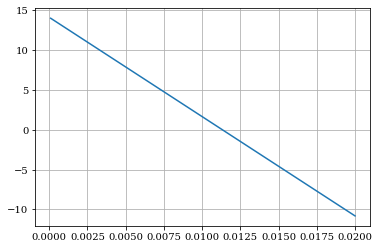

In [7]:
me = np.linspace(0.0001, 0.02)
loss = []
for i in me:
    temp = rsln_gmmb_fst(S0, G, T, r, sigma, m, i, A, Pi, N, X)
    loss.append(temp)
plt.plot(me, loss)
plt.grid()
f = interpolate.PchipInterpolator(loss[::-1], me[::-1])
me = f(0) # fair rate of me
float(me) # 0.011331094393465567

## Delta of GMMB and Put

In [11]:
def rsln_putdelta_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    delta_p1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)) / (ST)).real
    delta_p2 = (ifft(1j * w * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)) / (ST)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, delta_p1)
    f2 = interpolate.PchipInterpolator(ST, delta_p2)
    Delta_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(Delta_P)

rsln_putdelta_fst(S0, G, T, r, sigma, m, A, Pi, N, X) # -0.1771556790073902

-0.1771556790073902

In [12]:
def rsln_gmmbdelta_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    Delta_P = rsln_putdelta_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Delta_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        delta_re1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST)).real
        delta_re2 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, delta_re1)
        f2 = interpolate.PchipInterpolator(ST, delta_re2)
        Delta_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Delta = s(T) * Delta_P - np.sum(Delta_Re)
    return float(Delta)

rsln_gmmbdelta_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X) # -0.2981905805873755

-0.2981905805873755

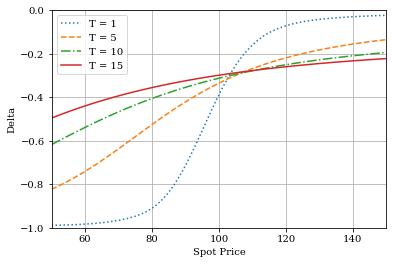

In [23]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = rsln_gmmbdelta_fst(i, G, time[j], r, sigma, m, me, A, Pi, N, X)
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.xlim((50, 150))
plt.ylabel('Delta')
# plt.ylim((-1, 0))
plt.grid()

## Gamma of GMMB and Put

In [13]:
def rsln_putgamma_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    gamma_p1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)) / (ST ** 2)).real
    gamma_p2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)) / (ST ** 2)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, gamma_p1)
    f2 = interpolate.PchipInterpolator(ST, gamma_p2)
    Gamma_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(Gamma_P)

rsln_putgamma_fst(S0, G, T, r, sigma, m, A, Pi, N, X) # 0.0026882310999570007

0.0026882310999570007

In [14]:
def rsln_gmmbgamma_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    Gamma_P = rsln_putgamma_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Gamma_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        gamma_re1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST ** 2)).real
        gamma_re2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)) / (ST ** 2)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, gamma_re1)
        f2 = interpolate.PchipInterpolator(ST, gamma_re2)
        Gamma_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB delta
    Gamma = s(T) * Gamma_P - np.sum(Gamma_Re)
    return float(Gamma)

rsln_gmmbgamma_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X) # 0.002546532187691512

0.002546532187691512

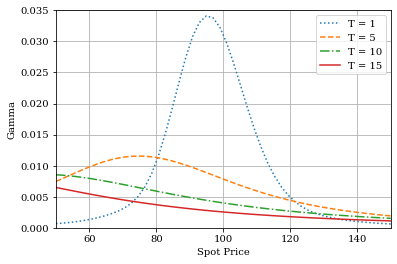

In [27]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = rsln_gmmbgamma_fst(i, G, time[j], r, sigma, m, me, A, Pi, N, X)
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.xlim((50, 150))
plt.ylabel('Gamma')
# plt.ylim((0, 0.035))
plt.grid()

## Vega of GMMB and Put

In [15]:
def rsln_putvega_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    vega1_p1 = ifft(-(1j * w + w ** 2) * sigma1 * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    vega1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, vega1_p1)
    f2 = interpolate.PchipInterpolator(ST, vega1_p2)
    Vega1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    vega2_p1 = ifft(0 * fft(payoff_p)).real
    vega2_p2 = ifft(-(1j * w + w ** 2) * sigma2 * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, vega2_p1)
    f2 = interpolate.PchipInterpolator(ST, vega2_p2)
    Vega2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Vega1_P), float(Vega2_P))

rsln_putvega_fst(S0, G, T, r, sigma, m, A, Pi, N, X) # 0.40319637636228045, 0.00011537208422641091

(0.40319637636228045, 0.00011537208422641091)

In [16]:
def rsln_gmmbvega_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    Vega1_P = rsln_putvega_fst(S0, G, T, r, sigma, m, A, Pi, N, X)[0]
    Vega2_P = rsln_putvega_fst(S0, G, T, r, sigma, m, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Vega1_Re = []
    Vega2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        vega1_re1 = ifft(-(1j * w + w ** 2) * sigma1 * t * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        vega1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, vega1_re1)
        f2 = interpolate.PchipInterpolator(ST, vega1_re2)
        Vega1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))           # FST method for sigma2
        vega2_re1 = ifft(0 * fft(payoff_r)).real
        vega2_re2 = ifft(-(1j * w + w ** 2) * sigma2 * t * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, vega2_re1)
        f2 = interpolate.PchipInterpolator(ST, vega2_re2)
        Vega2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Vega1_Re = np.sum(Vega1_Re) / 100
    Vega2_Re = np.sum(Vega2_Re) / 100
    # calculate GMMB delta
    Vega1 = (s(T) * Vega1_P - Vega1_Re)
    Vega2 = (s(T) * Vega2_P - Vega2_Re)
    return (float(Vega1), float(Vega2))

rsln_gmmbvega_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X) # 0.3496540335185916, 0.00010005127922891296

(0.3496540335185916, 0.00010005127922891296)

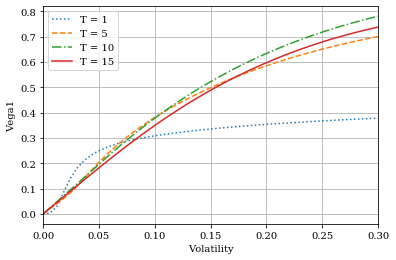

In [16]:
vol1 = np.linspace(0, 0.3)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in vol1:
        vol = [i, sigma[1]]
        temp = rsln_gmmbvega_fst(S0, G, time[j], r, vol, m, me, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(vol1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Volatility')
plt.xlim((0, 0.3))
plt.ylabel('Vega1')
plt.grid()

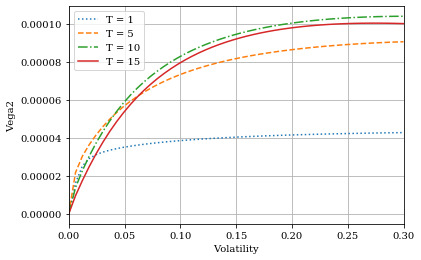

In [17]:
vol2 = np.linspace(0, 0.3)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in vol2:
        vol = [sigma[0], i]
        temp = rsln_gmmbvega_fst(S0, G, time[j], r, vol, m, me, A, Pi, N, X)[1]
        v.append(temp)
    plt.plot(vol2, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Volatility')
plt.xlim((0, 0.3))
plt.ylabel('Vega2')
plt.grid()

## Rho of GMMB and Put

In [17]:
def rsln_putrho_fst(S0, G, T, r, sigma, m, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for rho 1
    rho1_p1 = ifft((1j * w - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    rho1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, rho1_p1)
    f2 = interpolate.PchipInterpolator(ST, rho1_p2)
    Rho1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for rho 2
    rho2_p1 = ifft(0 * fft(payoff_p)).real
    rho2_p2 = ifft((1j * w - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, rho2_p1)
    f2 = interpolate.PchipInterpolator(ST, rho2_p2)
    Rho2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Rho1_P), float(Rho2_P))

rsln_putrho_fst(S0, G, T, r, sigma, m, A, Pi, N, X) # -5.099932282128968, -0.0005688685625264248

(-5.099932282128968, -0.0005688685625264248)

In [18]:
def rsln_gmmbrho_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    Rho1_P = rsln_putrho_fst(S0, G, T, r, sigma, m, A, Pi, N, X)[0]
    Rho2_P = rsln_putrho_fst(S0, G, T, r, sigma, m, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Rho1_Re = []
    Rho2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        rho1_re1 = ifft((1j * w - 1) * t * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        rho1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, rho1_re1)
        f2 = interpolate.PchipInterpolator(ST, rho1_re2)
        Rho1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))           # FST method for sigma2
        rho2_re1 = ifft(0 * fft(payoff_r)).real
        rho2_re2 = ifft((1j * w - 1) * t * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, rho2_re1)
        f2 = interpolate.PchipInterpolator(ST, rho2_re2)
        Rho2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Rho1_Re = np.sum(Rho1_Re) / 100
    Rho2_Re = np.sum(Rho2_Re) / 100
    # calculate GMMB delta
    Rho1 = (s(T) * Rho1_P - Rho1_Re)
    Rho2 = (s(T) * Rho2_P - Rho2_Re)
 
    return (float(Rho1), float(Rho2))

rsln_gmmbrho_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X) # -4.422688324278688, -0.00049332583270335

(-4.422688324278689, -0.00049332583270335)

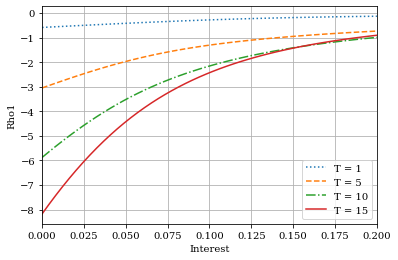

In [33]:
rho1 = np.linspace(0, 0.2)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in rho1:
        interest = [i, r[1]]
        temp = rsln_gmmbrho_fst(S0, G, time[j], interest, sigma, m, me, A, Pi, N, X)[3]
        v.append(temp)
    plt.plot(rho1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Interest')
plt.xlim((0, 0.2))
plt.ylabel('Rho1')
plt.grid()

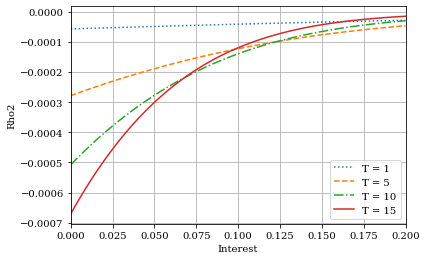

In [34]:
rho2 = np.linspace(0, 0.2)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in rho2:
        interest = [r[0], i]
        temp = rsln_gmmbrho_fst(S0, G, time[j], interest, sigma, m, me, A, Pi, N, X)[4]
        v.append(temp)
    plt.plot(rho2, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Interest')
plt.xlim((0, 0.2))
plt.ylabel('Rho2')
plt.grid()

## Mu

In [19]:
def rsln_gmmbmu_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    P = rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Mu_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        mu_re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(b(t) * payoff_r)).real
        mu_re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(b(t) * payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, mu_re1)
        f2 = interpolate.PchipInterpolator(ST, mu_re2)
        Mu_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB mu
    Mu = b(T) * s(T) * P - np.sum(Mu_Re)
    return float(Mu)

rsln_gmmbmu_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X) # -269.36857323086446

-269.36857323086446

## Mu2

In [24]:
def rsln_gmmbmu2_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X):
    P = rsln_put_fst(S0, G, T, r, sigma, m, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Mu2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        psi1 = 1j * (r1 - m - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
        psi2 = 1j * (r2 - m - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        mu2_re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(b(t) ** 2 * payoff_r)).real
        mu2_re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(b(t) ** 2 * payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, mu2_re1)
        f2 = interpolate.PchipInterpolator(ST, mu2_re2)
        Mu2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB mu
    Mu2 = b(T) ** 2 * s(T) * P - np.sum(Mu2_Re)
    return float(Mu2)

rsln_gmmbmu2_fst(S0, G, T, r, sigma, m, me, A, Pi, N, X) # 9533.132800960775

9533.132800960775

## Unhedged

In [20]:
scenario = 20

In [21]:
def rsln_mc(S0, G, T, r, sigma, m, A, Pi, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    F = np.zeros((T + 1, I))   
    cf = np.zeros((T + 1, I)) 
    for t in range(T + 1):
        for i in range(I):
            LogStock = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t: # Pr(tau_i > t) = exp(-lambda_i * t)
                p = random.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            SimRand = float(npr.standard_normal())
            LogFund = LogStock + (r1 - m - 0.5 * sigma1 ** 2) * tau1 + (r2 - m - 0.5 * sigma2 ** 2) * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2)
            F[t, i] = np.exp(LogFund)
    return F

Fund = rsln_mc(S0, G, T, r, sigma, m, A, Pi, scenario)

In [22]:
Fund.shape

(16, 20)

In [19]:
for j in range(T+1): # j = 0,1,2,...,15
    Unhedged = []
    for i in Fund[j]:
        temp = rsln_gmmb_fst(i, G, T-j, r, sigma, m, me, A, Pi, N, X)
        Unhedged.append(temp)
    print(j, np.mean(Unhedged), np.std(Unhedged))

0 -1.2256862191861728e-13 0.0
1 0.013528719771644819 3.736686096363884
2 1.3180190492932249 9.76953358233165
3 3.8512338573668985 9.02195088236844
4 6.187757186757756 12.448685412697138
5 1.3807356059605553 12.333432151977224
6 6.364425765714807 15.888161684742924
7 17.049833347441766 19.82371824112063
8 7.258606846853419 23.155183615386008
9 15.454038324881763 22.671852330387793
10 20.694856941122318 29.82534586348166
11 9.613222844541806 15.857879797410417
12 12.959301607824568 22.47079891467717
13 23.436485138410955 29.672960301650605
14 21.360562538587356 26.079613063038423
15 32.61864575721082 31.330408777191682


## Static

In [25]:
def portfolio(S, G, t, r, sigma, m, me, A, Pi, N, X):
    matrix = np.zeros((7, 8))
    # GMMB(15) = Put(15) + Put(16) + Put(17) + f(15) + f(16) + Z(15) + Z(16)
    matrix[0, 0] = rsln_gmmb_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    matrix[1, 0] = rsln_gmmbdelta_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    matrix[2, 0] = rsln_gmmbgamma_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    matrix[3, 0] = rsln_gmmbrho_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)[0]
    matrix[4, 0] = rsln_gmmbvega_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)[0]
    matrix[5, 0] = rsln_gmmbmu_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    matrix[6, 0] = rsln_gmmbmu2_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)

    for j in range(3): # Put(15), Put(16), Put(17)
        matrix[0, j+1] = rsln_put_fst(S, G, t+j, r, sigma, m, A, Pi, N, X)
        matrix[1, j+1] = rsln_putdelta_fst(S, G, t+j, r, sigma, m, A, Pi, N, X)
        matrix[2, j+1] = rsln_putgamma_fst(S, G, t+j, r, sigma, m, A, Pi, N, X)
        matrix[3, j+1] = rsln_putrho_fst(S, G, t+j, r, sigma, m, A, Pi, N, X)[0]
        matrix[4, j+1] = rsln_putvega_fst(S, G, t+j, r, sigma, m, A, Pi, N, X)[0]

    for j in range(2): # f(15), f(16), Z(15), Z(16)
        # f-Forward
        matrix[0, j+4] = s(15+j) * z(r, t+j, A, Pi) # Price
        matrix[3, j+4] = s(15+j) * rho1_z(r, t+j, A, Pi) # Rho1
        matrix[5, j+4] = b(15+j) * s(15+j) * z(r, t+j, A, Pi) # Mu
        matrix[6, j+4] = b(15+j) ** 2 * s(15+j) * z(r, t+j, A, Pi) # Mu2
        # Zero-coupon bond
        matrix[0, j+6] = z(r, t+j, A, Pi) # Price
        matrix[3, j+6] = rho1_z(r, t+j, A, Pi) # Rho1

    weights = np.zeros((8))
    weights[0] = -1
    weights[1:] = lin.solve(matrix[:, 1:], matrix[:, 0])
    return (matrix, weights)

print(portfolio(S0, G, T, r, sigma, m, me, A, Pi, N, X))
Matrix = portfolio(S0, G, T, r, sigma, m, me, A, Pi, N, X)[0]
weights0 = portfolio(S0, G, T, r, sigma, m, me, A, Pi, N, X)[1]
Matrix[0].dot(weights0)

(array([[-5.32907052e-14,  1.62877732e+01,  1.62696588e+01,
         1.62138049e+01,  5.19071239e-01,  4.94100012e-01,
         5.98556347e-01,  5.79390106e-01],
       [-2.98190581e-01, -1.77155679e-01, -1.69184956e-01,
        -1.61620730e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.54653219e-03,  2.68823110e-03,  2.50183456e-03,
         2.33437181e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-4.42268832e+00, -5.09993228e+00, -5.30951435e+00,
        -5.50328907e+00, -7.78525600e-02, -7.90477514e-02,
        -8.97740819e-02, -9.26927423e-02],
       [ 3.49654034e-01,  4.03196376e-01,  4.00255259e-01,
         3.96805075e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.69368573e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.49408135e+01, -1.58948539e+01,
         0.00000000e+00,  0.00000000e+00],
       [ 9.53313280e+03,  0.00000

1.8189894035458565e-12

In [26]:
def pv(S, t): # Present Value
    vector = np.zeros(8)
    vector[0] = rsln_gmmb_fst(S, G, t, r, sigma, m, me, A, Pi, N, X)
    for j in range(3):
        vector[j+1] = rsln_put_fst(S, G, t+j, r, sigma, m, A, Pi, N, X)
    for j in range(2): # f(15), f(16), Z(15), Z(16)
        vector[j+4] = s(15+j) * z(r, t+j, A, Pi)
        vector[j+6] = z(r, t+j, A, Pi)
    return vector

pv(S0, T) == Matrix[0]

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [26]:
for t in range(Fund.shape[0]): # j = 0,1,2,...,15
    Static = []
    for i in Fund[t]:
        pvt = pv(i, T-t) # present value at time t
        Static.append(pvt.dot(weights0))
    print(t, np.mean(Static), np.std(Static))

0 5.4569682106375694e-12 0.0
1 -1.4056538599155526 0.17400235225953742
2 -2.6436321548395427 1.390352742687767
3 -4.238503591997429 0.9943424312103151
4 -5.730668107622599 1.585031446249684
5 -8.379232620282544 3.3556808892059
6 -8.615181007201546 5.839337404028026
7 -10.156246290081018 8.831617939796807
8 -15.847135423611643 12.513186251916945
9 -21.083624250012125 15.515527013224132
10 -24.493140608981097 24.457909667396674
11 -33.28636261627811 33.292748755395266
12 -52.45987782179707 44.80163056998738
13 -108.76190522294799 69.51880719436359
14 -178.34374761651196 139.31841943250873
15 -411.2471610119585 280.09759151301733


## Semi-static

In [27]:
Weights = np.zeros((T+1, scenario, 8)) # (Weights4, Weights8, Weights12) * scenario * 8
Weights[0] = weights0
for t in [4, 8, 12]:
# for t in [0]:
    fund = Fund[t]
    for i in range(len(fund)):
        Weights[t, i] = portfolio(fund[i], G, T-t, r, sigma, m, me, A, Pi, N, X)[1]

In [28]:
for t in range(T + 1):
# for t in range(0, 6):
    Semi = []
    if t < 4:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(weights0))
    elif 4 <= t < 8:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[4, i]))
    elif 8 <= t < 12:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[8, i]))
    elif 12 <= t:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[12, i]))
    print(t, np.mean(Semi), np.std(Semi))

0 5.4569682106375694e-12 0.0
1 -1.3545980064071954 0.18135861603789694
2 -2.802673307697887 0.46596840487394786
3 -4.279072526861091 0.9806800450446443
4 1.3642420526593923e-13 5.588029001703266e-13
5 -1.4322757724577713 3.0746117932845007
6 -2.7256917420597473 2.4930135800959854
7 -4.396442868607631 4.683766499792808
8 4.227729277772596e-14 1.0972019998456065e-13
9 0.024684457012961757 7.301399368820454
10 -3.9244492904755277 18.430529263464727
11 -15.535782303123643 39.479202441890344
12 -3.732125719579926e-13 3.6189087051534536e-12
13 -692.8168591337673 2421.3721527296134
14 -1073.268831191543 4563.458655484952
15 -24.696478885696965 470.3483430485523


In [34]:
Weights = np.zeros((T+1, scenario, 8)) # (Weights4, Weights6, Weights9, Weights12) * scenario * 8
Weights[0] = weights0
for t in [5, 10]:
# for t in [0]:
    fund = Fund[t]
    for i in range(len(fund)):
        Weights[t, i] = portfolio(fund[i], G, T-t, r, sigma, m, me, A, Pi, N, X)[1]

In [35]:
for t in range(T + 1):
# for t in range(0, 6):
    Semi = []
    if t < 5:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(weights0))
    elif 5 <= t < 10:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[5, i]))
    elif 10 <= t:
        fund = Fund[t]
        for i in range(len(fund)):
            pvt = pv(fund[i], T-t)
            Semi.append(pvt.dot(Weights[10, i]))
    print(t, np.mean(Semi), np.std(Semi))

0 5.4569682106375694e-12 0.0
1 -1.3545980064071954 0.18135861603789694
2 -2.802673307697887 0.46596840487394786
3 -4.279072526861091 0.9806800450446443
4 -5.9679483022994875 1.6562822176118033
5 9.805489753489383e-14 4.568275916980753e-13
6 -17.25888714667367 71.9611295151768
7 -5.392759968272408 15.813220433362465
8 -17.1780167457972 56.83429119824759
9 -2.079832394815968 14.728240323932969
10 3.357314426466473e-14 2.0778204723994687e-13
11 -4782.791774936974 20803.844288616732
12 -26195.351253621182 110846.28570547113
13 -2213.294606256967 9685.779323949222
14 388.2942882568433 3018.351042167996
15 -10385.013820633914 41376.643677523076


In [ ]:
0 5.4569682106375694e-12 0.0
1 -1.3545980064071954 0.18135861603789694
2 -2.802673307697887 0.46596840487394786
3 -4.279072526861091 0.9806800450446443
4 1.3642420526593923e-13 5.588029001703266e-13
5 -1.4322757724577713 3.0746117932845007
6 -2.7256917420597473 2.4930135800959854
7 -4.396442868607631 4.683766499792808
8 4.227729277772596e-14 1.0972019998456065e-13
9 0.024684457012961757 7.301399368820454
10 -3.9244492904755277 18.430529263464727
11 -15.535782303123643 39.479202441890344
12 -3.732125719579926e-13 3.6189087051534536e-12
13 -692.8168591337673 2421.3721527296134
14 -1073.268831191543 4563.458655484952
15 -24.696478885696965 470.3483430485523

In [ ]:
0 5.4569682106375694e-12 0.0
1 -1.3545980064071954 0.18135861603789694
2 -2.802673307697887 0.46596840487394786
3 -2.0463630789890886e-13 8.163316611451703e-13
4 -1.403584624208935 2.7057953903066574
5 -5.959144999312161 16.10338279499015
6 8.597567102697212e-14 3.026102994975095e-13
7 -1.8530862823262566 7.22094179636566
8 -4.22217047060957 9.020787473597224
9 1.7408297026122456e-14 1.3731088997512733e-13
10 -658.6092393068996 2664.1098142865667
11 -129.94359871640043 444.78269780289094
12 -3.732125719579926e-13 3.6189087051534536e-12
13 -692.8168591337673 2421.3721527296134
14 -1073.268831191543 4563.458655484952
15 -24.696478885696965 470.3483430485523